### Problem description


### Mixed effects model  - Varying Intercepts

In fixed effect model coefficients of a linear model are the same for all samples. Variance is explained by ${\epsilon}_{i}$, which is assumed to be iid and ${\epsilon}_{i} = \mathcal N(0,{\sigma}_{\epsilon})$.

Likelihood 

\begin{equation}
{Wake}_{i} = {\beta}_{0} + {u}_{0} + ({\beta}_{1} + {u}_{1}){Treatment}_{i} + {\beta}_{2}{Genotype}_{i} + {\epsilon}_{ij}
\end{equation}

or alternatively

\begin{equation}
{Wake}_{i} = \mathcal N({\mu}_{i},{\sigma}_{\epsilon})\\
{\mu}_{i} = {\beta}_{0} + {u}_{0} + ({\beta}_{1} + {u}_{1}){Treatment}_{i} + {\beta}_{2}{Genotype}_{i}
\end{equation}

Weakly Informative Priors

\begin{equation}
{\beta}_{0} \sim \mathcal N(0,100)\\
{\beta}_{1} \sim \mathcal N(0,100)\\
{\beta}_{2} \sim \mathcal N(0,100)\\
{u}_{0} \sim \mathcal N(0,{\sigma}_{{u}_{0}} )\\
{u}_{1} \sim \mathcal N(0,{\sigma}_{{u}_{1}} )
\end{equation}

Hyperpriors
\begin{equation}
{\sigma}_{\epsilon} \sim \mathcal N(0,100)\\
{\sigma}_{{u}_{0}} \sim \mathcal N(0,100)
\end{equation}

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import stan
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data.csv")
data.head(10)

,id,NREM,REM,WAKE,Genotype,Treatment
0,6,53.423744,0.266785,46.309471,-1,0
1,2,60.544677,9.025433,30.429890,-1,0
2,18,20.456600,0.452080,79.091320,-1,10
3,15,26.550079,0.794913,72.655008,1,10
4,17,42.585377,0.664680,56.749943,1,0
5,3,22.544022,1.969416,75.486562,-1,10
6,14,22.010921,1.186217,76.802862,1,10
7,11,55.463138,5.519849,39.017013,1,0
8,13,47.309762,2.382782,50.307456,1,0
9,5,21.668910,0.230725,78.100365,1,10


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         33 non-null     int64  
 1   NREM       33 non-null     float64
 2   REM        33 non-null     float64
 3   WAKE       33 non-null     float64
 4   Genotype   33 non-null     int64  
 5   Treatment  33 non-null     int64  
dtypes: float64(3), int64(3)
memory usage: 1.7 KB


In [4]:
data_dict = data.to_dict()

N         = data.shape[0]
J         = len(set(data['id']))
subjid    = list(data_dict['id'].values())
treatment = list(data_dict['Treatment'].values())
genotype  = list(data_dict['Genotype'].values())
wake      = list(data_dict['WAKE'].values())

stan_data = {"N": N,
             "J": J,
             "y": wake,
             "id": subjid,
             "treat": treatment,
             "gen": genotype
            }

In [5]:
import nest_asyncio
nest_asyncio.apply()

stan_code = """
data {
  int<lower=0> N;                         // n.o. samples
  int<lower=0> J;                         // n.o. subj
  real y[N];                              // measurments, response var
  int id[N];                              // subject id
  int<lower=-1,upper=1> gen[N];            // predictor genotype
  real treat[N];                          // predictor treatment
}

parameters {
  real<lower=0> sigma;    // sheared standard deviation 
  vector[3] beta;         //fixed intercept and slopes
  
  vector<lower=0>[2] sigma_u;  //subj sd
  matrix[3,J] u;               //subj intercepts and slopes
}

model {
  //priors
  sigma_u[1] ~ normal(0,100);
  sigma_u[2] ~ normal(0,100);
  u[1] ~ normal(0,sigma_u[1]);     // subj intercepts
  u[2] ~ normal(0,sigma_u[2]);     // subj slopes
  beta ~ normal(0,100);
  
  real mu;
  for (i in 1:N){
      mu = beta[1] + u[1,id[i]] + (beta[2] + u[2,id[i]])*treat[i] + beta[3]*gen[i];
      y[i] ~ normal(mu, sigma);
      }
}

generated quantities {
    real ypred[N];
    real log_lik[N];
    real mu;
    
    for (i in 1:N){
      mu = beta[1] + u[1,id[i]] + (beta[2] + u[2,id[i]])*treat[i] + beta[3]*gen[i];
      ypred[i] = normal_rng(mu, sigma);
      log_lik[i] = normal_lpdf(y[i] | mu, sigma);
      }   
}

"""

posterior = stan.build(stan_code, data=stan_data)
fit = posterior.sample(num_chains=4, num_samples=4000)
df = fit.to_frame()

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/z0/1gmwp03s4lnc5_dw7cgfx0cw0000gn/T/httpstan_mq3gh0s2/model_ne52qtl7.stan', line 25, column 18: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/z0/1gmwp03s4lnc5_dw7cgfx0cw0000gn/T/httpstan_mq3gh0s2/model_ne52qtl7.stan', line 22, column 24: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/z0/1gmwp03s4lnc5_dw7cgfx0cw0000gn/T/httpstan_mq3gh0s2/model_ne52qtl7.stan', line 21, column 24: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   0% (2/20000)
Sampling:   0% (3/20000)
Sampling:   0% (4/20000)
Sampling:   1% (103/20000)
Sampling:   1% (202/20000)
Samplin

  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!


In [6]:
stats = az.convert_to_dataset(fit, group="sample_stats")

In [7]:
tree_depth = stats.tree_depth.to_numpy()

(array([3.0000e+00, 4.7000e+01, 8.1000e+01, 7.4000e+01, 0.0000e+00,
        7.7000e+01, 6.6000e+01, 9.0000e+01, 1.1900e+02, 1.5443e+04]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <BarContainer object of 10 artists>)

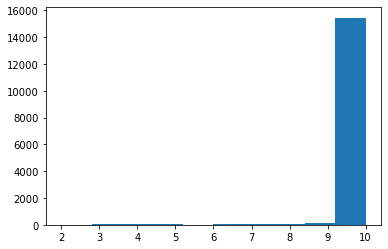

In [8]:
plt.hist(tree_depth.ravel())

In [9]:
divergence_data = stats.diverging.to_numpy()

In [10]:
sum(np.where(divergence_data==True)[0]==0), sum(np.where(divergence_data==True)[0]==1), sum(np.where(divergence_data==True)[0]==2), sum(np.where(divergence_data==True)[0]==3)

(17, 0, 21, 40)

In [11]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,7.559,1.407,4.997,10.261,0.018,0.013,5773.0,8926.0,1.00
beta[0],43.768,2.193,39.760,48.089,0.024,0.017,8538.0,6615.0,1.00
beta[1],3.072,0.388,2.341,3.801,0.005,0.003,7389.0,9722.0,1.00
beta[2],0.404,1.827,-3.065,3.809,0.016,0.015,13214.0,11746.0,1.00
sigma_u[0],3.972,2.354,0.080,7.872,0.081,0.057,636.0,407.0,1.01
...,...,...,...,...,...,...,...,...,...
log_lik[29],-5.029,1.130,-7.121,-3.011,0.018,0.013,3186.0,6831.0,1.00
log_lik[30],-3.107,0.301,-3.657,-2.575,0.003,0.002,11830.0,11596.0,1.00
log_lik[31],-3.554,0.562,-4.604,-2.640,0.007,0.005,5428.0,8378.0,1.00
log_lik[32],-3.301,0.405,-4.041,-2.604,0.005,0.004,4900.0,9768.0,1.00


In [12]:
print(df.describe().T[:15])

                 count        mean         std           min          25%  \
parameters                                                                  
lp__           16000.0  -97.329367   20.312466 -1.516423e+02  -112.388978   
accept_stat__  16000.0    0.852268    0.267211  1.981868e-40     0.881022   
stepsize__     16000.0    0.087115    0.033696  3.175770e-02     0.078130   
treedepth__    16000.0    9.874125    0.762933  2.000000e+00    10.000000   
n_leapfrog__   16000.0  996.643125  148.572183  3.000000e+00  1023.000000   
divergent__    16000.0    0.004875    0.069653  0.000000e+00     0.000000   
energy__       16000.0  127.316480   21.064331  2.293832e+01   114.279779   
sigma          16000.0    7.558822    1.406709  1.572675e+00     6.622186   
beta.1         16000.0   43.767542    2.193064  3.336294e+01    42.363818   
beta.2         16000.0    3.072446    0.387896  1.404283e+00     2.816739   
beta.3         16000.0    0.404002    1.826591 -8.538502e+00    -0.772477   

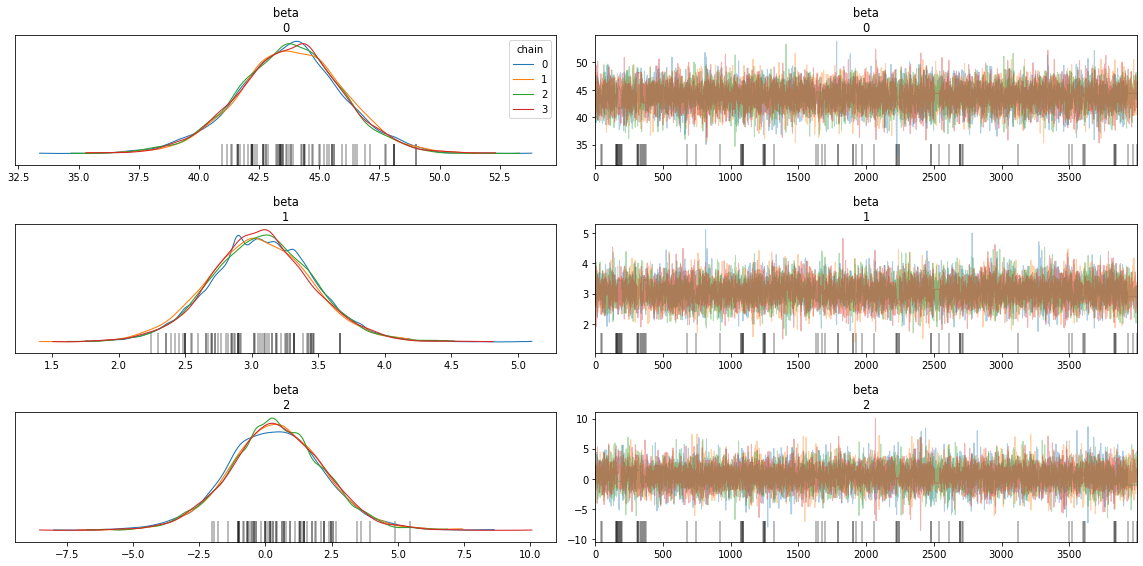

In [13]:
az.plot_trace(fit, var_names=['beta'], compact=False, legend=True, figsize=(16,8))
plt.tight_layout() 
plt.show()

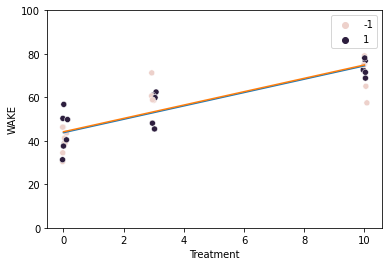

In [14]:
intercept = df["beta.1"].mean()
coeff1 = df["beta.2"].mean()
coeff2 = df["beta.3"].mean()

treat = [0, 3, 10]
genotype = [0, 1]

def jitter(vals):
    return vals + np.random.normal(0,0.05,vals.shape)

ypred = []
for i in range(len(genotype)):
    for j in range(len(treat)):
        ypred.append(intercept + coeff1*treat[j] + coeff2*genotype[i])
    
sns.scatterplot(data=data, x=jitter(data["Treatment"]), y="WAKE", hue="Genotype")
sns.lineplot(x=[0,3,10], y=ypred[:3])
sns.lineplot(x=[0,3,10], y=ypred[3:])
plt.ylim(0,100)
plt.show()

array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'beta\n2'}>], dtype=object)

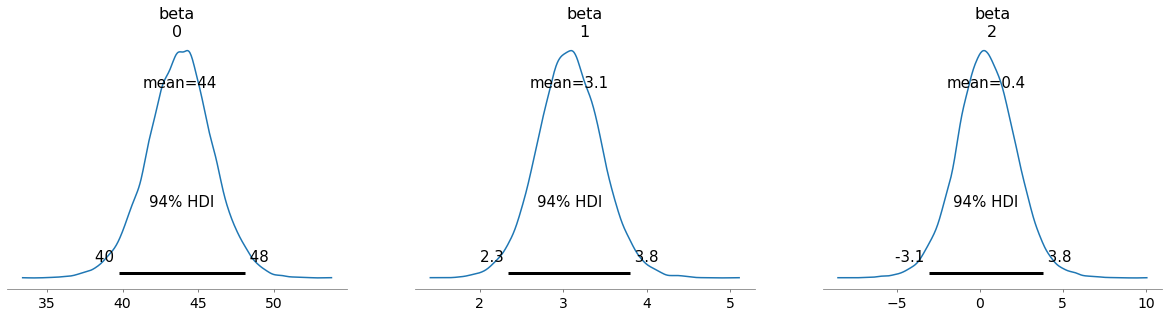

In [15]:
az.plot_posterior(fit, var_names=['beta'])

In [16]:
wtsal = data.index[(data["Genotype"]==1) & (data["Treatment"]==0)]
wt3   = data.index[(data["Genotype"]==1) & (data["Treatment"]==3)]
wt10  = data.index[(data["Genotype"]==1) & (data["Treatment"]==10)]

kosal = data.index[(data["Genotype"]==-1) & (data["Treatment"]==0)]
ko3   = data.index[(data["Genotype"]==-1) & (data["Treatment"]==3)]
ko10  = data.index[(data["Genotype"]==-1) & (data["Treatment"]==10)]

In [17]:
df.iloc[-1000:,67:100]

parameters,ypred.1,ypred.2,ypred.3,ypred.4,ypred.5,ypred.6,ypred.7,ypred.8,ypred.9,ypred.10,...,ypred.24,ypred.25,ypred.26,ypred.27,ypred.28,ypred.29,ypred.30,ypred.31,ypred.32,ypred.33
draws,,,,,,,,,,,,,,,,,,,,,
15000,39.477646,33.794935,77.885675,60.081354,53.380187,70.780514,66.214492,43.900363,40.790983,87.485565,...,43.688251,39.093422,47.493886,53.770467,56.684386,50.322477,58.271779,43.833674,44.803299,45.480029
15001,53.889976,28.927465,74.077073,67.198101,48.106880,78.324813,95.600909,44.923983,47.179412,67.995994,...,40.010389,54.901591,55.133105,41.724978,62.837695,40.334616,56.737001,42.352364,41.710100,50.017095
15002,49.913181,33.290103,75.229594,75.784872,49.873222,77.884060,65.790794,43.471260,36.252325,73.680780,...,31.537107,53.455901,40.405533,24.380933,58.728865,48.411866,37.332480,26.491052,51.285033,62.693281
15003,47.495074,25.960298,74.506277,80.373000,63.599376,67.224071,94.538162,26.327804,58.152977,86.351864,...,34.938540,46.040155,15.660173,49.798271,63.226489,39.593921,77.005074,44.447812,40.018555,50.607960
15004,54.695143,39.428157,63.366415,78.779340,61.842940,64.663172,68.033779,59.735940,48.891994,82.027469,...,40.519811,53.199012,43.183231,46.053149,62.791581,53.686748,53.936123,31.862408,26.083088,55.391033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,52.093405,40.733387,78.863311,85.930626,38.882175,65.745007,61.333356,49.444692,45.977766,72.648679,...,49.613789,49.810589,42.514965,47.688622,53.952729,55.962495,42.663979,43.770399,51.302412,46.311567
15996,50.435187,43.064896,80.612660,65.270404,27.942425,61.673355,72.378524,38.169656,41.431740,67.457602,...,47.626507,50.931352,54.958617,51.428225,64.809858,43.296571,47.581378,55.929648,51.466892,44.873671
15997,44.026181,51.031094,82.951203,89.143672,45.900405,71.387317,87.683733,41.349405,53.581446,100.759895,...,40.469791,51.617688,54.906408,51.375605,62.314895,60.698595,55.260691,42.184783,36.594660,54.711677


<AxesSubplot:ylabel='Density'>

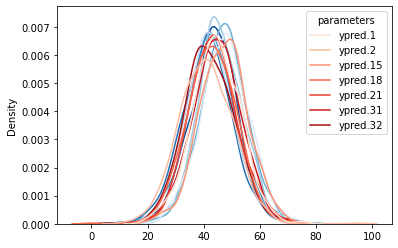

In [18]:
ypreds = df.iloc[-1000:,67:100].copy()

sns.kdeplot(data = ypreds.iloc[:,wtsal], palette="Blues")
sns.kdeplot(data = ypreds.iloc[:,kosal], palette="Reds")

<AxesSubplot:ylabel='Density'>

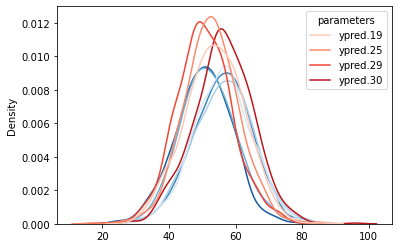

In [19]:
sns.kdeplot(data = ypreds.iloc[:,wt3], palette="Blues")
sns.kdeplot(data = ypreds.iloc[:,ko3], palette="Reds")

<AxesSubplot:ylabel='Density'>

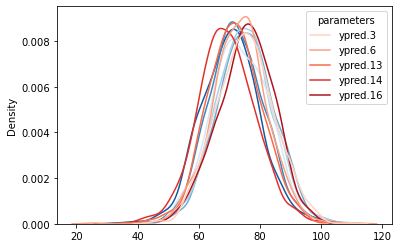

In [20]:
sns.kdeplot(data = ypreds.iloc[:,wt10], palette="Blues")
sns.kdeplot(data = ypreds.iloc[:,ko10], palette="Reds")

<AxesSubplot:>

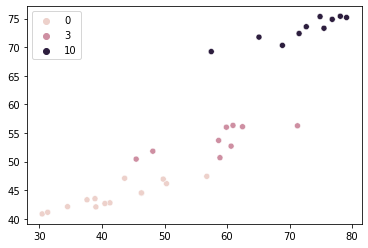

In [21]:
sns.scatterplot(x=wake, y=list(ypreds.mean()), hue=treatment)

<AxesSubplot:>

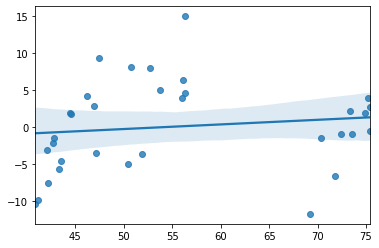

In [27]:
ypred = np.array(list(ypreds.mean()))
residuals = wake - ypred
sns.regplot(x=ypred, y=residuals)

<AxesSubplot:ylabel='Count'>

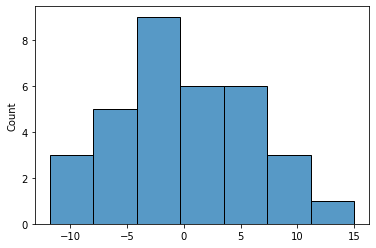

In [37]:
sns.histplot(residuals)

In [22]:
from psis import psisloo

loo, loos, ks = psisloo(fit['log_lik'].T)
print('PSIS-LOO value: {:.2f}'.format(loo))

/Users/shamsi/Desktop/BayesLMM/psis.py:288: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)
/Users/shamsi/anaconda3/envs/dlaalto/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


PSIS-LOO value: -119.75


<AxesSubplot:>

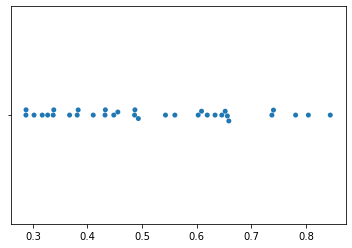

In [23]:
import seaborn as sns

sns.swarmplot(x=ks)
